In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_map(file_name):
    # Load data from file
    data = np.loadtxt(file_name, dtype=int)

    # Reshape data to a 2D array

    # Plot data
    plt.imshow(data, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Crystallized Particles')
    plt.title('Particle Crystallization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [ ]:
%%writefile projectCUDA1.cu
#include <iostream>
#include <sys/time.h>
#include <cstdlib>
#include <cstdio>
#include <cuda_runtime.h>

__device__ int width;
__device__ int height;
__device__ int* map;

int cwidth;
int cheight;
int* cmap;

double cpuSecond() {
    struct timeval tp;
    gettimeofday(&tp, NULL);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

typedef struct {
    int x;
    int y;
    int state;
    uint seed;
} Point;

__device__ float random_number(int seed){
    int x = seed;
    int m = 65537;
    int a = 75;
    int k = 10;
    for(int i=0; i<k; i++){
      x = (a*x)%m;
    }
    float ans = (float)x/(float)m;
    return ans;
}

__global__ void init_particles(Point* points, int number) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < number) {
        Point p;
        p.state = 0;
        p.x = (int)(random_number(i)*width);
        p.y = (int)(random_number((int)(random_number(i)*65537))*height);
        p.seed = i;
        points[i] = p;
    }
}

__device__ void move(Point& p) {
    p.seed = (int)(random_number(p.seed)*65537);
    int mov = p.seed % 4;
    if (mov == 0) {
        p.x += 1;
    } else if (mov == 1) {
        p.x -= 1;
    } else if (mov == 2) {
        p.y += 1;
    } else {
        p.y -= 1;
    }

    // condition
    if (p.x >= width) {
        p.x = 0;
    } else if (p.x < 0) {
        p.x = width - 1;
    }

    if (p.y >= height) {
        p.y = 0;
    } else if (p.y < 0) {
        p.y = height - 1;
    }
}

__device__ int check_occupied(int x, int y) {
    for (int x1 = -1; x1 <= 1; x1++) {
        for (int y1 = -1; y1 <= 1; y1++) {
            if (y1 == 0 && x1 == 0) continue;
            if (x1 + x < 0 || x1 + x >= width) continue;
            if (y1 + y < 0 || y1 + y >= height) continue;
            int j = ((y + y1) * width) + (x + x1);
            if (map[j] > 0) {
                return 1;
            }
        }
    }
    return 0;
}

__device__ void occupy(Point& p) {
    p.state = 1;
    int i = p.y * width + p.x;
    map[i] = 1;
}

__global__ void fill(Point* points, int number, int* changed) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < number) {
        Point p = points[i];
        if (p.state == 1) return;
        if (check_occupied(p.x, p.y)) {
            points[i].state = 1;
            int idx = p.y * width + p.x;
            map[idx] = 1;
            *changed = 1; // Indicate that a change was made
        }
    }
}

__global__ void move_particles(Point* points, int number) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < number) {
        if (points[i].state == 0) {
            move(points[i]);
        }
    }
}

void save_map(const char* file_name, int* map, int width, int height) {
    FILE* fp = fopen(file_name, "w");
    if (fp == NULL) {
        printf("Error opening the file %s\n", file_name);
        return;
    }
    for (int i = 0; i < width * height; i++) {
        if (i % width == 0) {
            fprintf(fp, "\n");
        }
        fprintf(fp, "%d ", map[i]);
    }
    fclose(fp);
}

int main() {
    cwidth = 200;
    cheight = 200;
    int number = 3000;
    int steps = 10000;
    int sx = 100;
    int sy = 100;
    int si = sy * cwidth + sx;

    double iStart = cpuSecond();

    cmap = (int*)malloc(sizeof(int) * cwidth * cheight);
    cudaMemcpyToSymbol(width, &cwidth, sizeof(int));
    cudaMemcpyToSymbol(height, &cheight, sizeof(int));
    int* d_map;
    cudaMalloc(&d_map, sizeof(int) * cwidth * cheight);
    cudaMemcpyToSymbol(map, &d_map, sizeof(int*));
    cudaMemcpy(d_map, cmap, sizeof(int) * cwidth * cheight, cudaMemcpyHostToDevice);

    Point* points;
    cudaMalloc(&points, sizeof(Point) * number);

    const int base = 1;
    int init_threads = base;
    int init_blocks = (number + base - 1) / base;
    if (number < base) {
        init_threads = number;
        init_blocks = 1;
    }
    init_particles<<<init_blocks, init_threads>>>(points, number);
    cudaDeviceSynchronize();

    printf("Initialization time: %.3f milliseconds\n", 1000 * (cpuSecond() - iStart));
    double sStart = cpuSecond();

    // Initialize starting point on device
    int initial_value = 1;
    cudaMemcpy(&d_map[si], &initial_value, sizeof(int), cudaMemcpyHostToDevice);

    int* d_changed;
    cudaMalloc(&d_changed, sizeof(int));

    for (int i = 0; i < steps; i++) {
        int changed;
        do {
            changed = 0;
            cudaMemcpy(d_changed, &changed, sizeof(int), cudaMemcpyHostToDevice);

            fill<<<init_blocks, init_threads>>>(points, number, d_changed);
            cudaDeviceSynchronize();

            cudaMemcpy(&changed, d_changed, sizeof(int), cudaMemcpyDeviceToHost);
        } while (changed);

        move_particles<<<init_blocks, init_threads>>>(points, number);
        cudaDeviceSynchronize();
    }

    printf("Simulation time: %.3f milliseconds\n", 1000 * (cpuSecond() - sStart));

    cudaMemcpy(cmap, d_map, sizeof(int) * cwidth * cheight, cudaMemcpyDeviceToHost);

    save_map("output_map.txt", cmap, cwidth, cheight);
    free(cmap);
    cudaFree(d_map);
    cudaFree(points);
    cudaFree(d_changed);
    return 0;
}

Overwriting projectCUDA1.cu


In [ ]:
!nvcc projectCUDA1.cu -o projectCUDA1
!./projectCUDA1

Initialization time: 105.301 milliseconds
Simulation time: 508.627 milliseconds


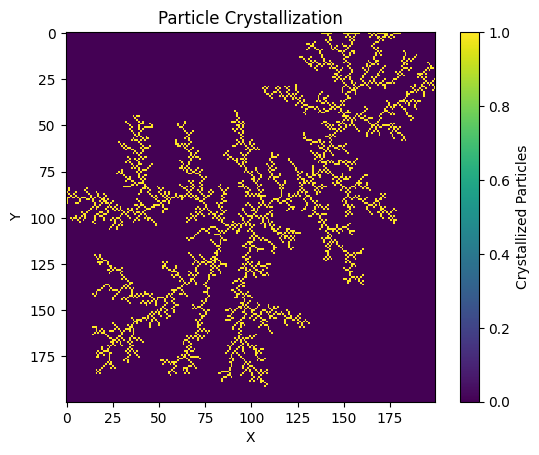

In [ ]:
plot_map("output_map.txt")

In [ ]:
%%writefile projectCUDA.c

#include <iostream>
#include <sys/time.h>
#include <cstdlib>
#include <cstdio>

int width;
int height;
int* map;

double cpuSecond() {
    struct timeval tp;
    gettimeofday(&tp, NULL);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

typedef struct {
    int x;
    int y;
    int state;
    uint seed;
} Point;

float random_number(int seed){
  int x = seed;
  int m = 65537;
  int a = 75;
  int k = 10;
  for(int i=0; i<k; i++){
    x = (a*x)%m;
  }
  float ans = (float)x/(float)m;
  return ans;
}

void initialize(Point* points, int number) {
    for (int i = 0; i < number; i++) {
        Point p;
        p.state = 0;
        p.x = (int)(random_number(i)*width);
        p.y = (int)(random_number((int)(random_number(i)*65537))*height);
        p.seed = i;
        points[i] = p;
    }
}

void move(Point &p) {
    p.seed = (int)(random_number(p.seed)*65537);
    int mov = p.seed % 4;
    if (mov == 0) {
        p.x += 1;
    } else if (mov == 1) {
        p.x -= 1;
    } else if (mov == 2) {
        p.y += 1;
    } else {
        p.y -= 1;
    }

    // condition
    if (p.x >= width) {
        p.x = 0;
    } else if (p.x < 0) {
        p.x = width - 1;
    }

    if (p.y >= height) {
        p.y = 0;
    } else if (p.y < 0) {
        p.y = height - 1;
    }
}

int check_occupied(int x, int y) {
    for (int x1 = -1; x1 <= 1; x1++) {
        for (int y1 = -1; y1 <= 1; y1++) {
            if (y1 == 0 && x1 == 0) continue;
            if (x1 + x < 0 || x1 + x >= width) continue;
            if (y1 + y < 0 || y1 + y >= height) continue;
            int j = ((y + y1) * width) + (x + x1);
            if (map[j] > 0) {
                return 1;
            }
        }
    }
    return 0;
}

void occupy(Point &p) {
    p.state = 1;
    int i = p.y * width + p.x;
    map[i] = 1;
}

void fill(Point* points, int number) {
    int changed;
    do {
        changed = 0;
        for (int i = 0; i < number; i++) {
            Point p = points[i];
            if (p.state == 1) continue;
            if (check_occupied(p.x, p.y)) {
                points[i].state = 1;
                int idx = p.y * width + p.x;
                map[idx] = 1;
                changed = 1;
            }
        }
    } while (changed);
}

void move_particles(Point* points, int number) {
    for (int i = 0; i < number; i++) {
        if (points[i].state == 0) {
            move(points[i]);
        }
    }
}

void save_map(const char* file_name, int* map, int width, int height) {
    FILE *fp = fopen(file_name, "w");
    if (fp == NULL) {
        printf("Error opening the file %s\n", file_name);
        return;
    }
    for (int i = 0; i < width * height; i++) {
        if (i % width == 0) {
            fprintf(fp, "\n");
        }
        fprintf(fp, "%d ", map[i]);
    }
    fclose(fp);
}

int main() {
    width = 200;
    height = 200;
    int number = 3000;
    int steps = 10000;
    int sx = 100;
    int sy = 100;
    int si = sy * width + sx;

    double iStart = cpuSecond();

    map = (int*)malloc(sizeof(int) * width * height);

    Point* points = (Point*)malloc(sizeof(Point) * number);
    initialize(points, number);

    printf("Initialization time: %.3f milliseconds\n", 1000 * (cpuSecond() - iStart));
    double sStart = cpuSecond();

    map[si] = 1;

    for (int i = 0; i < steps; i++) {
        fill(points, number);
        move_particles(points, number);
    }

    printf("Simulation time: %.3f milliseconds\n", 1000 * (cpuSecond() - sStart));

    save_map("output_map1.txt", map, width, height);
    free(map);
    free(points);
    return 0;
}

Overwriting projectCUDA.c


In [ ]:
!g++ projectCUDA.c -o projectCUDA
!./projectCUDA

Initialization time: 1.292 milliseconds
Simulation time: 2165.490 milliseconds


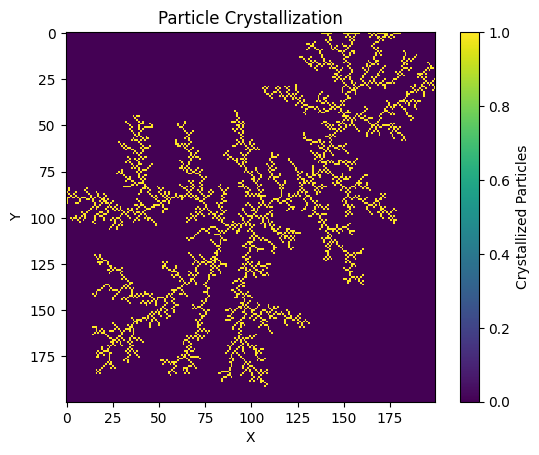

In [ ]:
plot_map("output_map1.txt")

In [ ]:
def compare_files(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()

        if len(lines1) != len(lines2):
            print("Files have different number of lines.")
            return False

        for i, (line1, line2) in enumerate(zip(lines1, lines2)):
            if line1 != line2:
                print(f"Difference found on line {i + 1}:")
                print(f"File1: {line1.strip()}")
                print(f"File2: {line2.strip()}")
                return False

    print("Files are identical.")
    return True

# Example usage:
file1 = "output_map.txt"
file2 = "output_map1.txt"
compare_files(file1, file2)


Files are identical.


True